In [40]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
import seaborn as sns
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops
from skimage.draw import polygon,rectangle,polygon_perimeter
import math
import csv
import os
import sklearn
import pandas as pd
from scipy.stats import f_oneway
from itertools import combinations
from scipy.stats import ttest_ind


In [4]:
file_path = r"data_2\dataset.csv"
data = pd.read_csv(file_path)

In [5]:
data.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
0,0.184,106401.5980,103157.1785,1293.4311,592,1150,0.7705,0.2313
1,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313
2,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313
3,0.184,106400.7710,103156.2771,1293.4311,592,1150,0.7705,0.2313
4,0.184,106402.8029,103158.1105,1293.4311,592,1150,0.7705,0.2313


In [6]:
data.tail()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
295,0.1387,92597.5043,90066.2099,1181.6302,449,1093,0.7577,0.1645
296,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644
297,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644
298,0.1387,92597.5043,90066.2099,1181.6302,449,1093,0.7577,0.1645
299,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  300 non-null    float64
 1   Feature2  300 non-null    float64
 2   Feature3  300 non-null    float64
 3   Feature4  300 non-null    float64
 4   Feature5  300 non-null    int64  
 5   Feature6  300 non-null    int64  
 6   Feature7  300 non-null    float64
 7   Feature8  300 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 18.9 KB


In [8]:
data.shape

(300, 8)

In [9]:
data.isnull().sum()

Feature1    0
Feature2    0
Feature3    0
Feature4    0
Feature5    0
Feature6    0
Feature7    0
Feature8    0
dtype: int64

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Feature1,300.0,0.152698,0.020580,0.1121,0.1410,0.1548,0.166800,0.1903
Feature2,300.0,96826.305201,6497.177463,83528.1779,93554.2273,97513.0050,101489.859200,108193.5226
Feature3,300.0,92651.430769,5500.413412,80950.3309,90039.6155,93062.3804,95713.572500,103158.1105
Feature4,300.0,1215.729927,42.300775,1156.8513,1176.8997,1233.7962,1256.129100,1293.4311
Feature5,300.0,466.726667,37.045465,412.0000,449.0000,463.0000,469.000000,592.0000
Feature6,300.0,1122.213333,34.962682,1080.0000,1086.0000,1141.0000,1149.000000,1174.0000
Feature7,300.0,0.758105,0.012816,0.7294,0.7486,0.7535,0.769500,0.7897
Feature8,300.0,0.184671,0.028877,0.1298,0.1671,0.1866,0.204725,0.2399


In [25]:
def ploty(x, y, size1=10, size2=1.5, interval=10, title="plotting"):
    # Create a 2x1 grid of subplots
    fig, axs = plt.subplots(1, 1, figsize=(size1, 2 * size2))

    # First Plot: Entire Dataset
    axs.plot(x, y)
    total_data_points = len(x)
    interval = total_data_points // interval
    x_ticks_positions = x[::interval]
    axs.set_xticks(x_ticks_positions)
    axs.legend(y.columns)
    axs.set_xlabel('X-axis')
    axs.set_ylabel('Y-axis')
    axs.set_title(title)
    axs.grid()

    # # Second Plot: Subset of 50,000 Data Points
    # axs[1].plot(x[limit1:limit2], y[limit1:limit2])  # Plot a subset of data
    # axs[1].set_xlabel('X-axis')
    # axs[1].set_ylabel('Y-axis')
    # axs[1].set_title("Subset of 50,000 Data Points")
    # axs[1].grid()

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

# Example usage
# ploty(x, y)

In [13]:
data.columns

Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
       'Feature7', 'Feature8'],
      dtype='object')

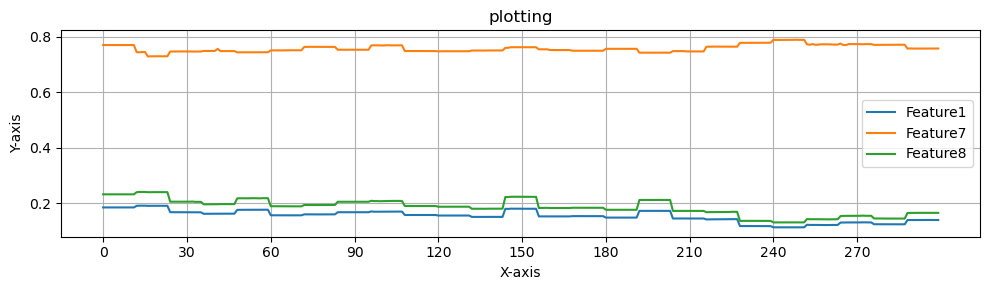

In [26]:
ploty(data.index,data[["Feature1","Feature7","Feature8"]])

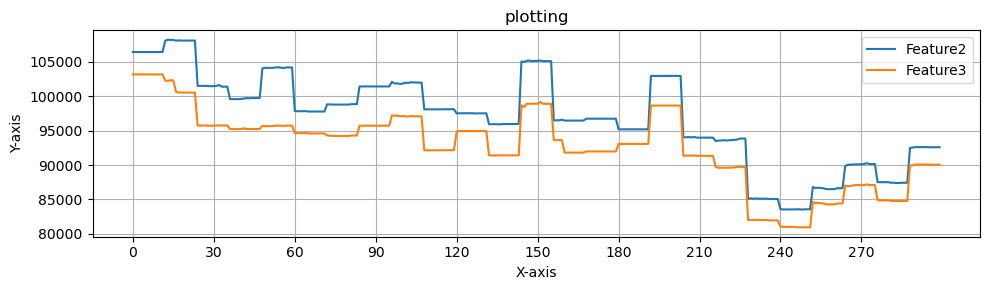

In [27]:
ploty(data.index,data[["Feature2","Feature3"]])

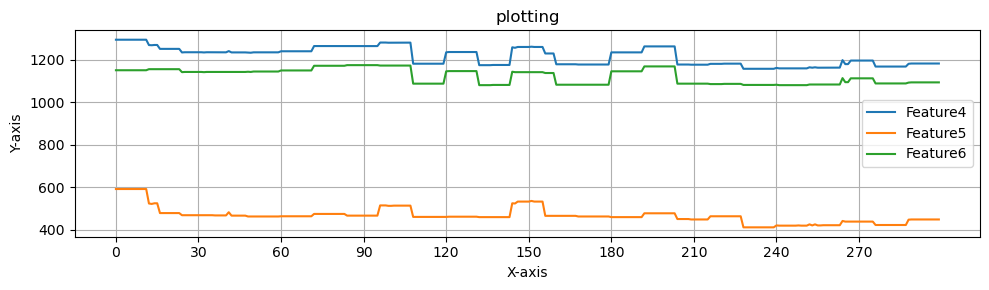

In [28]:
ploty(data.index,data[["Feature4","Feature5","Feature6"]])

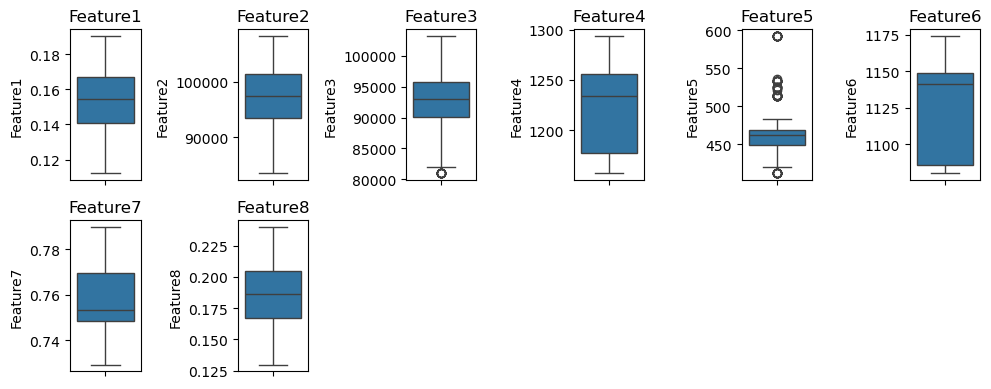

In [34]:
plt.figure(figsize=(10, 4))
for i, col in enumerate(data.columns, 1):
    plt.subplot(2, 6, i)
    sns.boxplot(y=data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

<Axes: >

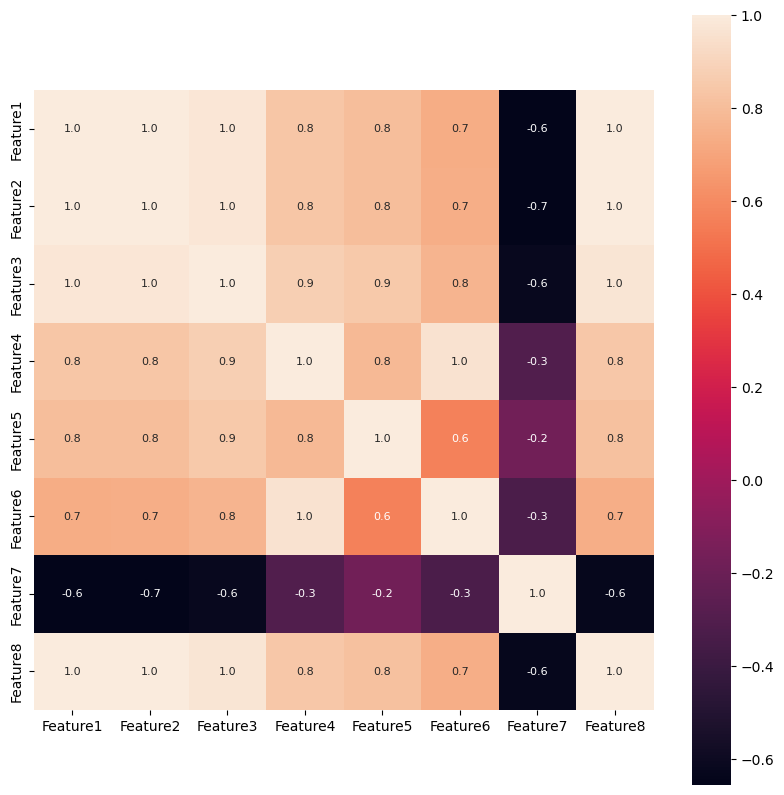

In [30]:
correlation = data.corr()
plt.figure(figsize = (10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8})
     

In [37]:
l:list = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
        'Feature8']


In [38]:
# Perform one-way ANOVA across all features
f_stat, p_value = f_oneway(*[data[col].values for col in l])

# Display results
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Significant differences exist between the features.")
else:
    print("No significant differences between the features.")

F-Statistic: 61240.95
P-Value: 0.0000
Significant differences exist between the features.


In [42]:
# Generate all unique pairs of columns from 'l'
pairwise_results:list = []
for feature1, feature2 in combinations(l, 2):
    # Perform t-test
    t_stat, p_value = ttest_ind(data[feature1], data[feature2])
    pairwise_results.append({
        'Feature Pair': f'{feature1} vs {feature2}',
        'T-statistic': t_stat,
        'P-value': p_value
    })

# Convert the results to a DataFrame
pairwise_results_df = pd.DataFrame(pairwise_results)

# Print the results
print(pairwise_results_df)

            Feature Pair  T-statistic        P-value
0   Feature1 vs Feature2  -258.124111   0.000000e+00
1   Feature1 vs Feature3  -291.753926   0.000000e+00
2   Feature1 vs Feature4  -497.731134   0.000000e+00
3   Feature1 vs Feature5  -218.145375   0.000000e+00
4   Feature1 vs Feature6  -555.868598   0.000000e+00
5   Feature1 vs Feature8   -15.616924   2.308055e-46
6   Feature2 vs Feature3     8.494373   1.580998e-16
7   Feature2 vs Feature4   254.878161   0.000000e+00
8   Feature2 vs Feature5   256.876119   0.000000e+00
9   Feature2 vs Feature6   255.129170   0.000000e+00
10  Feature2 vs Feature8   258.124026   0.000000e+00
11  Feature3 vs Feature4   287.917625   0.000000e+00
12  Feature3 vs Feature5   290.278126   0.000000e+00
13  Feature3 vs Feature6   288.214795   0.000000e+00
14  Feature3 vs Feature8   291.753826   0.000000e+00
15  Feature4 vs Feature5   230.718537   0.000000e+00
16  Feature4 vs Feature6    29.514826  8.118805e-119
17  Feature4 vs Feature8   497.717985   0.0000